In [1]:
from IPython.display import display, Markdown, HTML
from tbh.paths import REPO_ROOT_PATH, DATA_FOLDER
analysis_path = REPO_ROOT_PATH / "remote_cluster" / "outputs" / "48092744_age_spec_target" / "task_1"

In [2]:
import tbh.plotting as pl
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt 
plt.style.use("ggplot")

intervention_scenarios = ["scenario_1", "scenario_2", "scenario_3"]
all_scenarios = ['baseline'] + intervention_scenarios
unc_dfs = {
    sc: pd.read_parquet(analysis_path / f"uncertainty_df_{sc}.parquet") for sc in all_scenarios
}
diff_outputs_dfs = {
    sc: pd.read_parquet(analysis_path / f"diff_quantiles_df_ref_baseline_{sc}.parquet") for sc in intervention_scenarios
}
idata = az.from_netcdf(analysis_path / "idata.nc")

In [3]:
import yaml

with open(analysis_path / "details.yaml" , "r") as f:
    docs = list(yaml.safe_load_all(f))

model_config = docs[1]
analysis_config = docs[2]

In [4]:
from tbh import runner_tools as rt
from tbh.model import get_tb_model
from estival.model import BayesianCompartmentalModel


params, priors, tv_params = rt.get_parameters_and_priors()

model = get_tb_model(model_config, tv_params)
bcm = BayesianCompartmentalModel(model, params, priors, rt.targets)

# Background and Introduction
## Aims and simulated population
This modelling analysis aims to explore and compare various scenarios of screening for TB and TBI in Kiribati. It focuses on simulating what the next phase of PEARL screening could potentially look like under different diagnostic approaches and considering different screening rates.
For this purpose, the simulated population is the population of South Tarawa excluding that already screened by the end of 2025. Thus, the model is designed to capture the part of South Tarawa extending from Nanikai to Bonriki.

We will use the data collected to date through the PEARL study to estimate TB and TBI prevalence in the population that has already been screened and will assume that similar epidemiological patterns apply to the population yet to be screened. These prevalence estimates will serve as calibration targets for the modelling exercise, with certain parameters automatically adjusted to ensure that the model reproduces the observed estimates.

## Modelled scenarios


# Model calibration and modelled baseline epidemic
## Model fits to data
@fig-multifit shows the model fits to calibration targets derived from data collected during the intervention. The black dots represent the observed quantities, whereas model estimates are shown in blue (solid line: median; dark shade: interquartile range; light shade: 95% CI).

In [5]:
#| fig-pos: "H" 
#| label: fig-multifit
#| fig-cap: "Model fits to observations. The black dots represent the observed quantities, whereas model estimates are shown in blue (solid line: median; dark shade: interquartile range; light shade: 95% CI)."
fig = pl.plot_all_model_fits(unc_dfs['baseline'], bcm)
display(fig)
plt.close(fig)

/Users/rrag0004/Documents/Code/tb_hierarchical/code/tbh/plotting.py:283: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



<Figure size 4500x3240 with 8 Axes>

## Parameters' posterior distributions
@fig-posteriors shows a comparison between the prior and posterior distributions of the calibrated model parameters. The prior distributions, shown in grey, reflect our knowledge about the parameter values **before** running the analysis and before considering the data used for calibration. Prior distributions are often chosen to be non-informative when there is very little evidence available to inform the parameter value. The posterior distributions, displayed in red, show the parameter values accepted during model calibration. These are the values found to be 'plausible', or appropriate to produce reasonable fits to the observations.

In [6]:
#| fig-pos: "H" 
#| label: fig-posteriors
#| fig-cap: "Prior and posterior distributions of calibrated parameters. Prior distributions are shown in grey, and posterior distributions in red."
fig = pl.plot_post_prior_comparison(idata, analysis_config['burn_in'], req_vars=list(bcm.priors.keys()),
                              priors=list(bcm.priors.values()))
display(fig)
plt.close(fig)

<Figure size 7590x3622.5 with 12 Axes>

## Model outputs for non-fitted epidemic indicators
### Past epidemic trajectories

In [7]:
# selected_outputs = ['tb_incidence_per100k', 'tb_mortality_per100k', 'viable_tbi_prevalence_perc', 'passive_detection_rate_clin']
selected_outputs = ['tb_incidence_per100k', 'tb_mortality_per100k', 'passive_detection_rate_clin']

for output in selected_outputs:
    out_name = output if output not in pl.title_lookup else pl.title_lookup[output]
    display(Markdown(f"**{out_name}**"))
    fig, ax = plt.subplots(figsize=(5, 3))
    x_min = 1950 if output == "passive_detection_rate_clin" else 1990
    pl.plot_model_fit_with_uncertainty(ax, unc_dfs['baseline'], output, bcm, x_lim=(x_min, 2025), ylab_fontsize=10)
    display(fig)
    plt.close(fig)


**TB incidence (/100k)**

<Figure size 1500x900 with 1 Axes>

**TB mortality (/100k)**

<Figure size 1500x900 with 1 Axes>

**Passive detec. rate (/y), clinical TB**

<Figure size 1500x900 with 1 Axes>

### Estimated age-specific TST positivity rates

In [8]:
#| fig-pos: "H" 
#| label: fig-age_tbi
#| fig-cap: "Age-specific TST positivity rate (observed and modelled). Red crosses indicate the measured TST positivity rate (%). Blue boxes represent the model estimates (median, interquartile range, 95% CI)."
fig = pl.plot_age_spec_tbi_prev(unc_dfs['baseline'], bcm)
display(fig)
plt.close(fig)

<Figure size 2400x1500 with 1 Axes>

# Projected trajectories under various screening scenarios

In [9]:
outputs_to_plot = ['tb_incidence_per100k', 'tbi_prevalence_perc', 'tb_mortality_per100k']

for sc in intervention_scenarios:
    display(Markdown(f"## {sc}"))
    for output in outputs_to_plot:
        out_name = output if output not in pl.title_lookup else pl.title_lookup[output]
        display(Markdown(f"**{out_name}**"))
        fig, ax = plt.subplots(figsize=(5, 3))
        pl.plot_two_scenarios(ax, unc_dfs, output, scenarios=['baseline', sc], xlim=(2015,2050), include_unc=True, ylab_fontsize=10)
        display(fig)
        plt.close(fig)


## scenario_1

**TB incidence (/100k)**

<Figure size 1500x900 with 1 Axes>

**TBI prevalence (%)**

<Figure size 1500x900 with 1 Axes>

**TB mortality (/100k)**

<Figure size 1500x900 with 1 Axes>

## scenario_2

**TB incidence (/100k)**

<Figure size 1500x900 with 1 Axes>

**TBI prevalence (%)**

<Figure size 1500x900 with 1 Axes>

**TB mortality (/100k)**

<Figure size 1500x900 with 1 Axes>

## scenario_3

**TB incidence (/100k)**

<Figure size 1500x900 with 1 Axes>

**TBI prevalence (%)**

<Figure size 1500x900 with 1 Axes>

**TB mortality (/100k)**

<Figure size 1500x900 with 1 Axes>

# Estimated cumulative impact of interventions on TB disease and mortality

## Cumulative outputs over 2020-2050

In [10]:
for output in ['cum_tb_incidence', 'cum_tb_mortality']:
    
    fig, ax = plt.subplots(1, 1)
    pl.plot_final_size_compare(ax,unc_dfs, output, all_scenarios)
    display(fig)
    plt.close(fig)

<Figure size 1650x1050 with 1 Axes>

<Figure size 1650x1050 with 1 Axes>

## TB episodes and deaths averted over 2020-2050 (ref. no intervention)

In [11]:
for output in ["TB_averted", "TB_averted_relative"]:
    fig, ax = plt.subplots(1, 1)
    pl.plot_diff_outputs(ax, diff_outputs_dfs, output, intervention_scenarios)
    display(fig)
    plt.close(fig)

<Figure size 1650x1050 with 1 Axes>

<Figure size 1650x1050 with 1 Axes>

# Model structure and parameters

![Model structure. Not shown: age-stratification; natural mortality (all compartments); TB mortality (clinical TB compartments); self-recovery (subclinical TB compartments); reinfection from 'Contained', 'Cleared' and 'Recovered' compartments transitions back to 'Incipient'.](tb_model.png){#fig:tb_model width=100%}

In [12]:
#| tab-params: "H" 
#| label: tab-params
#| tab-cap: "Model parameters"
params_file_path = DATA_FOLDER / "parameters.xlsx"
param_df = pd.read_excel(params_file_path, sheet_name="constant")
param_df["value_or_prior"] = param_df.apply(
    lambda row: f"{row['distribution']} ({row['distri_param1']}, {row['distri_param2']})"
    if pd.notna(row['distribution'])
    else str(row['value']),
    axis=1
)
param_df = param_df.rename(columns={"full_text": "definition"})
param_df = param_df.fillna("")
md_table = param_df[["parameter", "definition", "value_or_prior", "unit"]].to_markdown(index=False)  # index=False to skip the row numbers
display(Markdown(md_table))

| parameter                    | definition                                                                              | value_or_prior       | unit   |
|:-----------------------------|:----------------------------------------------------------------------------------------|:---------------------|:-------|
| raw_transmission_rate        | Effective rate of transmission (before adjusting for infectiousness)                    | uniform (0.1, 10.0)  |        |
| mixing_factor_cc             | Child-child mixing, relative to adult-adult mixing                                      | 1.0                  |        |
| mixing_factor_ca             | Child-adult mixing, relative to adult-adult mixing                                      | 1.0                  |        |
| rel_sus_contained            | Rel. risk of reinfection from 'contained' compartment (ref. 'mtb-naïve')                | uniform (0.2, 0.5)   |        |
| rel_sus_cleared              | Rel. risk of reinfection from 'cleared' compartment (ref. 'mtb-naïve')                  | uniform (0.5, 1.0)   |        |
| rel_sus_recovered            | Rel. risk of reinfection from 'recovered' compartment (ref. 'mtb-naïve')                | uniform (0.5, 1.0)   |        |
| rel_sus_children             | Rel. susceptibility to infection for under 15 year-old individuals (ref. 15 and over)   | 0.5                  |        |
| rel_infectiousness_subclin   | Rel. infectiousness of subclinical TB (ref. clinical TB)                                | 0.5                  |        |
| rel_infectiousness_lowinf    | Rel. infectiousness of 'less infectious' TB (ref. 'more infectious' TB)                 | 0.4                  |        |
| progression_rate_age0        | Rate of progression from 'incipient' to TB disease (age 0-4)                            | 2.4                  | /year  |
| progression_rate_age5        | Rate of progression from 'incipient' to TB disease (age 5-14)                           | 2.0                  | /year  |
| progression_rate_age15       | Rate of progression from 'incipient' to TB disease (age 15 and over)                    | 0.1                  | /year  |
| progression_prop_infectious  | Proportion of incident TB that is 'more infectious'                                     | 0.5                  | /year  |
| containment_rate_age0        | Rate of transition from 'incipient' to 'contained' (age 0-4)                            | 4.4                  | /year  |
| containment_rate_age5        | Rate of transition from 'incipient' to 'contained' (age 5-14)                           | 4.4                  | /year  |
| containment_rate_age15       | Rate of transition from 'incipient' to 'contained' (age 15 and over)                    | 2.0                  | /year  |
| breakdown_rate               | Rate of transition from 'contained' to 'incipient' (all ages)                           | uniform (0.01, 1.0)  | /year  |
| clearance_rate               | Rate of transition from 'contained' to 'cleared' (all ages)                             | uniform (0.01, 0.03) | /year  |
| clinical_progression_rate    | Rate of progression from subclinical to clinical TB                                     | uniform (0.5, 5.0)   | /year  |
| clinical_regression_rate     | Rate of transition from clinical to subclinical TB                                      | 1.0                  | /year  |
| infectiousness_gain_rate     | Rate of progression from 'less infectious' to 'more infectious' TB                      | uniform (0.5, 5.0)   | /year  |
| infectiousness_loss_rate     | Rate of transition from 'more infectious' to 'less infectious' TB                       | 1.0                  | /year  |
| tb_mortality_rate_inf        | Rate of TB mortality for 'more infectious' clinical disease                             | 0.389                | /year  |
| tb_mortality_rate_lowinf     | Rate of TB mortality for 'less infectious' clinical disease                             | 0.025                | /year  |
| self_recovery_rate           | Rate of self-recovery for subclinical TB                                                | 0.4                  | /year  |
| recent_detection_rate        | Annual rate of TB detection in 2020                                                     | uniform (0.1, 5.0)   | /year  |
| tx_duration                  | Average TB treatment duration                                                           | 0.5                  | year   |
| pct_neg_tx_death             | Percentage of deaths among negative TB treatment outcomes                               | 40.0                 | %      |
| prev_se_incipient            | Probability of TST positivity for 'incipient' category                                  | 0.75                 |        |
| prev_se_contained            | Probability of TST positivity for 'contained' category                                  | 0.75                 |        |
| prev_se_cleared              | Probability of TST positivity for 'cleared' category                                    | uniform (0.2, 0.5)   |        |
| prev_se_subclin_lowinf_pearl | Probability PEARL-positive for 'subclinical' and 'less infectious' category             | 0.95                 |        |
| prev_se_clin_lowinf_pearl    | Probability PEARL-positive for 'clinical' and 'less infectious' category                | 0.95                 |        |
| prev_se_subclin_inf_pearl    | Probability PEARL-positive for 'subclinical' and 'more infectious' category             | 0.95                 |        |
| prev_se_clin_inf_pearl       | Probability PEARL-positive for 'clinical' and 'more infectious' category                | 0.95                 |        |
| tpt_completion_perc          | TPT completion percentage                                                               | 70.0                 | %      |
| prev_se_subclin_lowinf_cxr   | Probability CXR-positive for 'subclinical' and 'less infectious' category               | 0.5                  |        |
| prev_se_clin_lowinf_cxr      | Probability CXR-positive for 'clinical' and 'less infectious' category                  | 0.9                  |        |
| prev_se_subclin_inf_cxr      | Probability CXR-positive for 'subclinical' and 'more infectious' category               | 0.6                  |        |
| prev_se_clin_inf_cxr         | Probability CXR-positive for 'clinical' and 'more infectious' category                  | 0.9                  |        |
| rel_detection_subclin        | Relative detection rate of subclinical TB under passive case finding (ref. clinical TB) | 0.0                  |        |

In [60]:
from importlib import reload
reload(pl);

/Users/rrag0004/Documents/Code/tb_hierarchical/.pixi/envs/default/lib/python3.10/site-packages/arviz/plots/pairplot.py:224: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


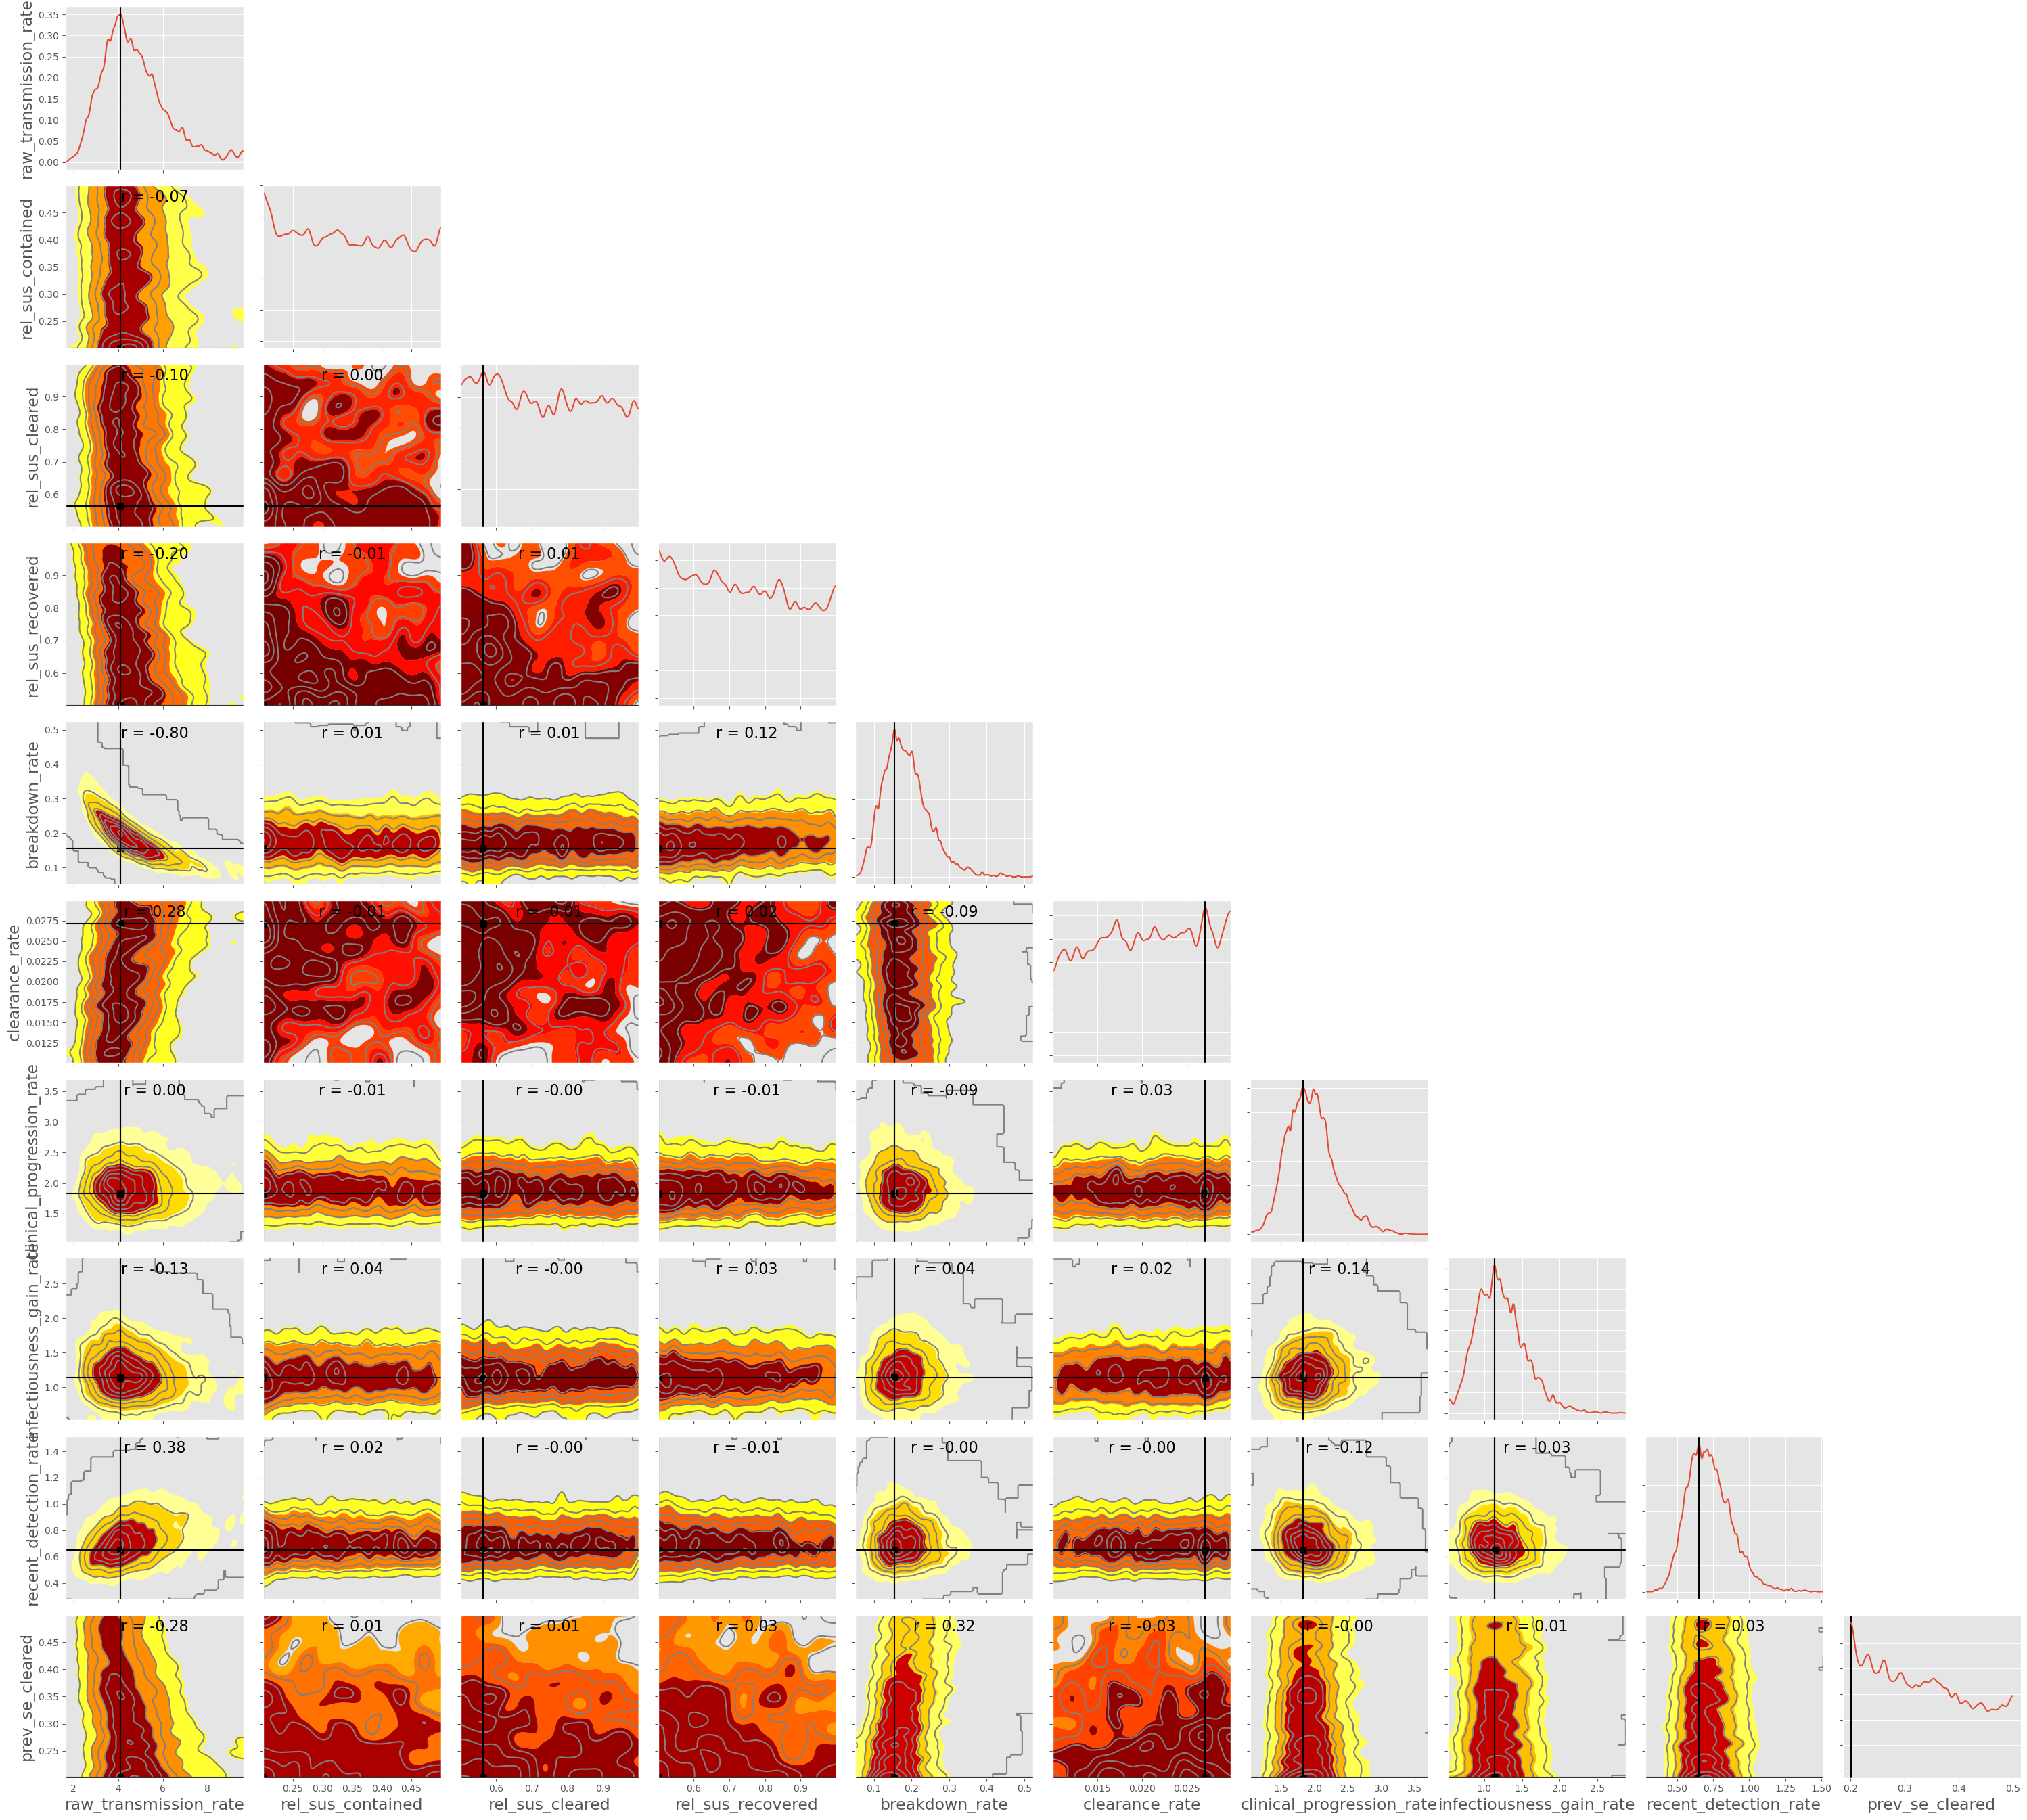

In [61]:
#| fig-pos: "H" 
#| label: fig-pairs
#| fig-cap: "Pairwise relationships between calibrated parameters, with 2D kernel density estimates shown. The posterior mode is indicated by a black dot."
fig = pl.plot_posterior_pairs(idata, analysis_config['burn_in'], list(bcm.priors.keys()), 'kde')
display(fig)
plt.close(fig)